### Generate data via sampling from MOGP given known inputs and hidden vector

In [1]:
import numpy as np
import random
import torch
from gpytorch.kernels import ScaleKernel, RBFKernel
from linear_operator.operators import KroneckerProductLinearOperator
from torch import Tensor
from torch.distributions import MultivariateNormal
from lvmogp_svi import LVMOGP_SVI
from gaussian_likelihood import GaussianLikelihood
from variational_elbo import VariationalELBO
from tqdm import trange
from torch.optim.lr_scheduler import StepLR
from util_functions import *

# without missing data
# Compare to synth_data_expri.ipynb, this section is based on another implementation 

In [3]:
# load in synthetic data (only call this function once)
n_total = 700 # totally 700 points for C
n_outputs = 20
X_true, C_total, sample_total_data = tidily_sythetic_data_from_MOGP(n_C=n_total, n_X=n_outputs)

In [4]:
print('total data targets', sample_total_data.shape)
print('total data inputs', C_total.shape)

total data targets torch.Size([14000])
total data inputs torch.Size([700])


In [5]:
# In without missing data case, each output has the same set of inputs.
# Below we obtain train inputs and test inputs.

n_train = 50
n_test = n_total - n_train

train_index = random.sample(range(n_total), n_train)
C_train = C_total[train_index]

test_index = [index for index in range(n_total) if index not in train_index]
C_test = C_total[test_index]

assert C_train.shape[0] == n_train
assert C_test.shape[0] == n_test

In [6]:
# extract train/test target data from sample_total_data based on their indices.

sample_train_index = train_index
for i in range(1,20): # 20 outputs, except the first one is already included
    sample_train_index = np.concatenate((sample_train_index, list(np.array(train_index) + n_total*i)))

sample_test_index = test_index
for i in range(1,20):
    sample_test_index = np.concatenate((sample_test_index, list(np.array(test_index) + n_total*i)))

assert sample_train_index.shape[0] == n_train*20
assert sample_test_index.shape[0] == n_test*20
assert np.isin(sample_train_index, sample_test_index).sum() == 0

sample_train_data = sample_total_data[sample_train_index]
sample_test_data = sample_total_data[sample_test_index]

## Set up and train Model

In [7]:
# define hyper-parameters
n_X = X_true.shape[0]
n_C = C_train.shape[0] # also data_dim
n_total = n_X * n_C
index_dim = 1
latent_dim = 2
n_inducing_C = 15
n_inducing_X = 30
pca = False
Y_train = sample_train_data

C = C_train

# specify model
my_model = LVMOGP_SVI(n_X, n_C, index_dim, latent_dim, n_inducing_C, n_inducing_X, Y_train.reshape(n_X, -1), pca=pca)

# Likelihood & training objective
likelihood = GaussianLikelihood()
mll = VariationalELBO(likelihood, my_model, num_data=n_total)

# load in partially-trained model
load_model = False
load_likelihood = False
if load_model:
    model_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/models/model_weights.pth'
    state_dict = torch.load(model_path)
    my_model.load_state_dict(state_dict)

if load_likelihood:
    likelihood_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/models/likelihood_weights.pth'
    state_dict = torch.load(likelihood_path)
    likelihood.load_state_dict(state_dict)

# optimizer and scheduler
optimizer = torch.optim.Adam([
    {'params': my_model.parameters()},
    {'params': likelihood.parameters()} # likelihood parameter is fixed.
], lr=0.03)

scheduler = StepLR(optimizer, step_size=50, gamma=0.95)  # every 50 iterations，learning rate multiple 0.9

# have a look at parameters
for name, param in my_model.named_parameters():
    print(name, param.size())

print('---' * 15) 
for name, param in likelihood.named_parameters():
    print(name, param.size())


'''
# change initialization of some parameters
for name, param in my_model.named_parameters():
    if 'covar_module_X.raw_outputscale' in name:
        param.data = torch.tensor(0.49).to(param.device)
    if 'covar_module_X.base_kernel.raw_lengthscale' in name:
        param.data = torch.tensor([[0.5 for _ in range(latent_dim)]]).to(param.device)
    if 'covar_module_C.raw_outputscale' in name:
        param.data = torch.tensor(0.51).to(param.device)
    if 'covar_module_C.base_kernel.raw_lengthscale' in name:
        param.data = torch.tensor([[0.5 for _ in range(index_dim)]]).to(param.device)
'''
# whether fixing the likelihood noise
# likelihood.noise_covar.raw_noise.data = torch.tensor([-0.01]).to(likelihood.noise_covar.raw_noise.device)


# start training!
loss_list = []
n_iterations = 1500 # 10000
iterator = trange(n_iterations, leave=True)
batch_size_X = 20
batch_size_C = 50
model_max_grad_norm = 15
likeli_max_grad_norm = 0.7


my_model.train()
for i in iterator: 
    batch_index_X, batch_index_C = proper_sample_index_X_and_C(my_model, batch_size_X, batch_size_C)
    assert len(batch_index_X) == len(batch_index_C)
    # core code is here 
    optimizer.zero_grad()
    sample_X = my_model.sample_latent_variable()  # a full sample returns latent x across all n_X TODO: more efficient?
    sample_batch_X = sample_X[batch_index_X]
    sample_batch_C = C[batch_index_C]
    output_batch = my_model(sample_batch_X, sample_batch_C) # q(f)
    batch_index_Y = inhomogeneous_index_of_batch_Y(batch_index_X, batch_index_C, n_X, n_C)
    loss = -mll(output_batch, Y_train[batch_index_Y]).sum()
    loss_list.append(loss.item())
    iterator.set_description('Loss: ' + str(float(np.round(loss.item(),3))) + ", iter no: " + str(i))
    loss.backward()

    # Clip gradients
    torch.nn.utils.clip_grad_norm_(my_model.parameters(), model_max_grad_norm)
    torch.nn.utils.clip_grad_norm_(likelihood.parameters(), likeli_max_grad_norm)

    optimizer.step()
    scheduler.step()

# print(loss_list)


variational_strategy.inducing_points_X torch.Size([30, 2])
variational_strategy.inducing_points_C torch.Size([15, 1])
variational_strategy._variational_distribution.variational_mean torch.Size([450])
variational_strategy._variational_distribution.chol_variational_covar_X torch.Size([30, 30])
variational_strategy._variational_distribution.chol_variational_covar_C torch.Size([15, 15])
X.q_mu torch.Size([20, 2])
X.q_log_sigma torch.Size([20, 2])
covar_module_X.raw_outputscale torch.Size([])
covar_module_X.base_kernel.raw_lengthscale torch.Size([1, 2])
covar_module_C.raw_outputscale torch.Size([])
covar_module_C.base_kernel.raw_lengthscale torch.Size([1, 1])
---------------------------------------------
noise_covar.raw_noise torch.Size([1])


Loss: 0.631, iter no: 1499: 100%|██████████| 1500/1500 [03:29<00:00,  7.17it/s]


### Continue Training

In [ ]:
'''
my_model.train()
n_iterations_2 = 1000
iterator_2 = trange(n_iterations_2, leave=True)

for i in iterator_2: 
    batch_index_X, batch_index_C = proper_sample_index_X_and_C(my_model, batch_size_X, batch_size_C)
    assert len(batch_index_X) == len(batch_index_C)
    # core code is here 
    optimizer.zero_grad()
    sample_X = my_model.sample_latent_variable()  # a full sample returns latent x across all n_X TODO: more efficient?
    sample_batch_X = sample_X[batch_index_X]
    sample_batch_C = C[batch_index_C]
    output_batch = my_model(sample_batch_X, sample_batch_C) # q(f)
    batch_index_Y = inhomogeneous_index_of_batch_Y(batch_index_X, batch_index_C, n_X, n_C)
    loss = -mll(output_batch, Y_train[batch_index_Y]).sum()
    loss_list.append(loss.item())
    iterator.set_description('Loss: ' + str(float(np.round(loss.item(),3))) + ", iter no: " + str(i))
    loss.backward()
    optimizer.step()
    scheduler.step()
'''

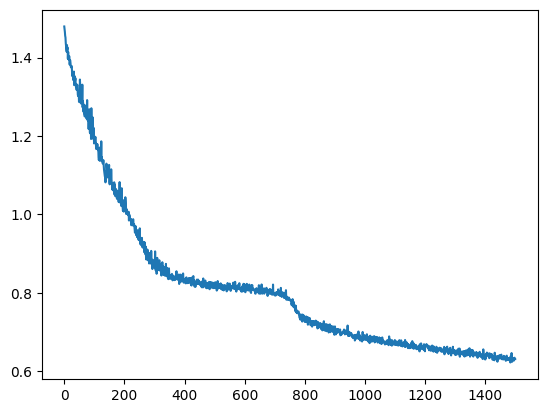

In [8]:
import matplotlib.pyplot as plt

plt.plot(loss_list)

In [9]:
print('After Training, have a look at fitted kernel parameters...\n')
for name, param in my_model.named_parameters():
    if 'covar_module_X.raw_outputscale' in name:
        print(name)
        print(param.data)
        print('\n')
    if 'covar_module_X.base_kernel.raw_lengthscale' in name:
        print(name)
        print(param.data)
        print('\n')
    if 'covar_module_C.raw_outputscale' in name:
        print(name)
        print(param.data)
        print('\n')
    if 'covar_module_C.base_kernel.raw_lengthscale' in name:
        print(name)
        print(param.data)
        print('\n')
    
for name, param in likelihood.named_parameters():
    print(name)
    print(param.data)
    print('\n')

After Training, have a look at fitted kernel parameters...

covar_module_X.raw_outputscale
tensor(0.3367)


covar_module_X.base_kernel.raw_lengthscale
tensor([[0.2115, 0.2487]])


covar_module_C.raw_outputscale
tensor(0.3366)


covar_module_C.base_kernel.raw_lengthscale
tensor([[1.0599]])


noise_covar.raw_noise
tensor([-7.9726])




In [ ]:
my_model.variational_strategy.inducing_points_C.data.shape

## Testing

In [ ]:
# prediction output for grid (total) inputs.
my_model.eval()

batch_size_X = 20
batch_size_C = 700 # this number must equal to n_total = 700 !
sample_X = my_model.X.q_mu # TODO: try other meaningful approaches

batch_index_X = np.array([[i]*batch_size_C for i in range(batch_size_X)]).reshape(-1).tolist() 
batch_index_C = [i for i in range(batch_size_C)] * batch_size_X 

assert len(batch_index_X) == len(batch_index_C)

sample_batch_X = sample_X[batch_index_X]
sample_batch_C = C_total[batch_index_C]
grid_output_batch = my_model(sample_batch_X, sample_batch_C) # q(f)

### Train/Test data RMSE

In [ ]:
train_data_predict = grid_output_batch.loc.detach()[sample_train_index]
train_rmse = (train_data_predict - sample_train_data).square().mean().sqrt()
print('Train RMSE', train_rmse)

test_data_predict = grid_output_batch.loc.detach()[sample_test_index]
test_rmse = (test_data_predict - sample_test_data).square().mean().sqrt()
print('Test RMSE', test_rmse)

### Visual Inspect

In [ ]:
# Pick the index of the funtion to show
multiplier = 7 # 0 - 19 (in total 20 output functions)

train_input = C_train
train_start = train_input.shape[0] * multiplier
train_end = train_start + train_input.shape[0]
train_target = sample_train_data[train_start:train_end]


test_input = C_test
test_start = test_input.shape[0] * multiplier
test_end = test_start + test_input.shape[0]
test_target = sample_test_data[test_start:test_end]

gp_input = C_total
gp_start = gp_input.shape[0] * multiplier
gp_end = gp_start + gp_input.shape[0]
gp_target = sample_total_data[gp_start:gp_end]

gp_pred_mean = grid_output_batch.loc.detach()[gp_start:gp_end]
gp_pred_std = grid_output_batch.stddev.detach()[gp_start:gp_end]

In [ ]:
plot_traindata_testdata_fittedgp(train_X=train_input, train_Y=train_target, test_X=test_input, test_Y=test_target, gp_X=gp_input, gp_pred_mean=gp_pred_mean, gp_pred_std=gp_pred_std, inducing_points_X=my_model.variational_strategy.inducing_points_C.detach(), n_inducing_C=n_inducing_C) # NOTE: input is C not X

### True v.s. Fitted latent variables

In [ ]:
plot_true_and_fitted_latent(X_true, my_model.X.q_mu.detach(), torch.nn.functional.softplus(my_model.X.q_log_sigma.detach()))